In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import requests
from matplotlib import pyplot as plt
from matplotlib import colors
from datetime import date

In [2]:
#Weather station IDs used by Tonga MET website
station_ids = {
        'Vavau':3,
        'Fatai':12,
        'Fangatongo':25,
        'Koloa':24,
        'Longomapu':22,
        'Tongatapu':1
}
print(station_ids.keys())

dict_keys(['Vavau', 'Fatai', 'Fangatongo', 'Koloa', 'Longomapu', 'Tongatapu'])


In [3]:
#Base pieces of URL to request data from Tonga MET server
# EXAMPLE: http://met.gov.to:2016/weather_analysis.do?stationId=3&timeType=1&date=09/03/2019%20-%2009/10/2019
# split the above into pieces and change only the varable elements (weather stations, date range)
base_url = 'http://met.gov.to:2016/weather_analysis_excel.do?stationId='
mid_url = '&timeType=1&date=01/01/1980%20-%20'

#Formatting date to use in web query & for excel file name
today = date.today()
end_date = str(today.month).zfill(2)+'/'+str(today.day).zfill(2)+'/'+str(today.year)
end_date_filename = str(today.month).zfill(2)+str(today.day).zfill(2)+str(today.year)

In [4]:
#Downloading data and writing to local disk
for station in station_ids.keys():
    # Downloading data from MET & handling missing values
    url = base_url+str(station_ids[station])+mid_url+end_date
    df = pd.read_excel(url).fillna(np.nan)
    df = df.replace(-999,np.nan)
    # Formatting timestamp for aggregations
    df['Time']    = pd.to_datetime(df['Time'])
    df['Year']    = df['Time'].dt.year
    df['Month']   = df['Time'].dt.month
    df['Week']    = df['Time'].dt.week
    df['Phenophase'] = pd.cut(df['Month'],[-1,6,8,11,15], labels=['No Flower','Pre-Onset','Flowering','NF'])
    df['Phenophase'] = df['Phenophase'].replace({'NF':'No Flower'})
    # Calculating degree day indicators
    df['Delta']   = df[df.columns[3]] - df[df.columns[2]]
    df['GDD_25']  = df[df.columns[3]].clip(lower=25).multiply(0.5)+df[df.columns[2]].clip(lower=25).multiply(0.5)-25
    df['Heat_30'] = df[df.columns[3]].clip(lower=30).multiply(0.5)+df[df.columns[2]].clip(lower=30).multiply(0.5)-30
    df['Chill_20']= 20-df[df.columns[3]].clip(upper=20).multiply(0.5)-df[df.columns[2]].clip(upper=20).multiply(0.5)
    df['Chill_18']= 18-df[df.columns[3]].clip(upper=18).multiply(0.5)-df[df.columns[2]].clip(upper=18).multiply(0.5)
    # Writing data to disk as excel file
    df.to_excel(station+'-01011980 to '+end_date_filename+'.xls')
    print(station, url)

Vavau http://met.gov.to:2016/weather_analysis_excel.do?stationId=3&timeType=1&date=01/01/1980%20-%2009/17/2019
Fatai http://met.gov.to:2016/weather_analysis_excel.do?stationId=12&timeType=1&date=01/01/1980%20-%2009/17/2019
Fangatongo http://met.gov.to:2016/weather_analysis_excel.do?stationId=25&timeType=1&date=01/01/1980%20-%2009/17/2019
Koloa http://met.gov.to:2016/weather_analysis_excel.do?stationId=24&timeType=1&date=01/01/1980%20-%2009/17/2019
Longomapu http://met.gov.to:2016/weather_analysis_excel.do?stationId=22&timeType=1&date=01/01/1980%20-%2009/17/2019
Tongatapu http://met.gov.to:2016/weather_analysis_excel.do?stationId=1&timeType=1&date=01/01/1980%20-%2009/17/2019


In [5]:
# Defining parameters for generating weekly mean figures - setting plot range, filename, title
figure_dict = {
    'min_temp':{'min_val':17, 'max_val':32, 'name':'mean weekly minimum temperature (C)','df_column':str(df.columns[2])},
    'max_temp':{'min_val':17, 'max_val':32, 'name':'mean weekly maximum temperature (C)', 'df_column':str(df.columns[3])},
    'mean_rain':{'min_val':0, 'max_val':75, 'name':'mean weekly rainfall(mm)','df_column':str(df.columns[6])},
    'Delta':{'min_val':0, 'max_val':12, 'name':'Temperature Spread (C)', 'df_column':'Delta'},
    'GDD_25':{'min_val':0, 'max_val':5, 'name':'Growing Degree Days over 25C', 'df_column':'GDD_25'},
    'Heat_30':{'min_val':0, 'max_val':2, 'name':'Heat Days over 30C', 'df_column':'Heat_30'},
    'Chill_20':{'min_val':0, 'max_val':2, 'name':'Chill Days under 20C', 'df_column':'Chill_20'},
    'Chill_18':{'min_val':0, 'max_val':2, 'name':'Chill Days under 18C', 'df_column':'Chill_18'}
}

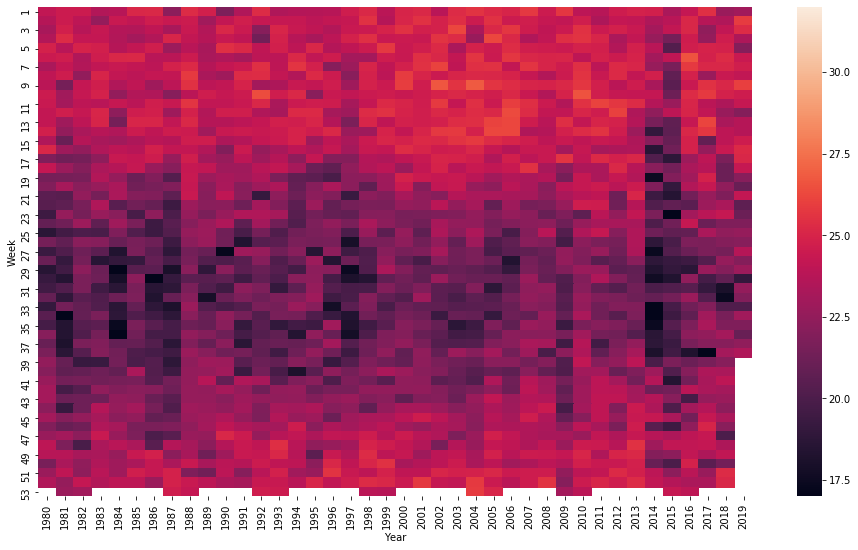

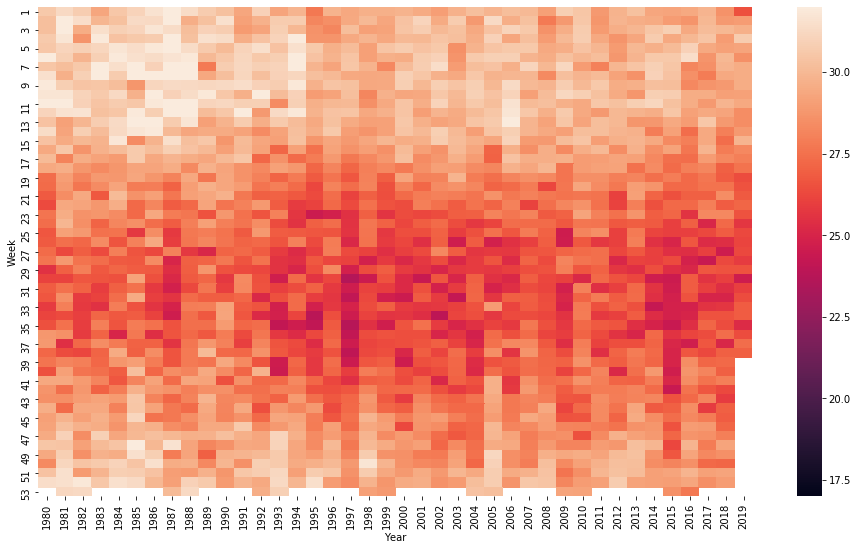

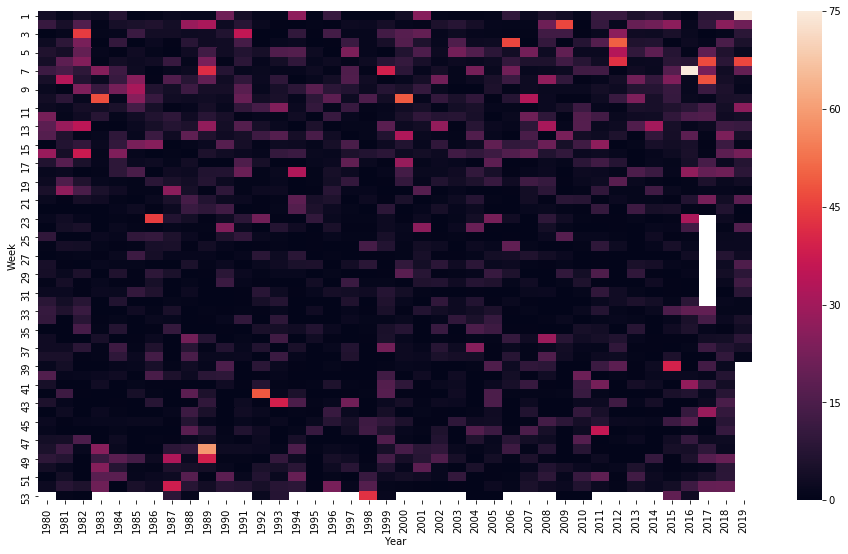

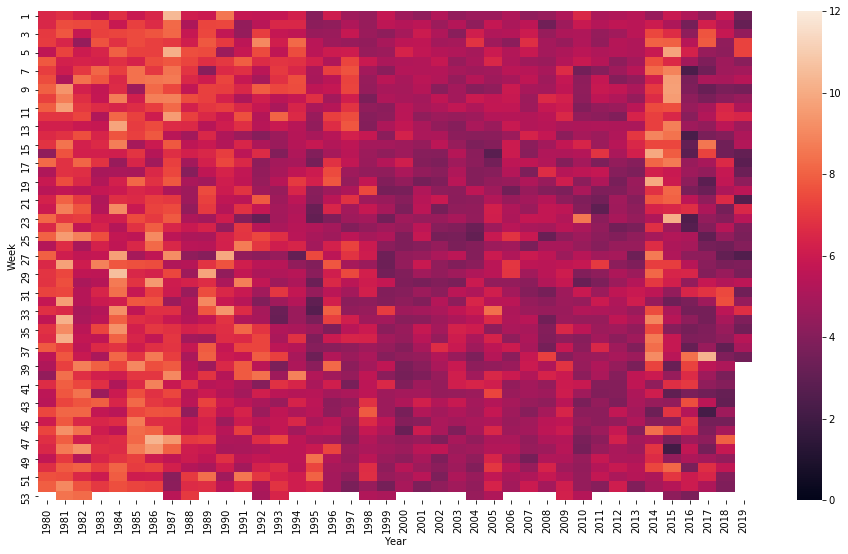

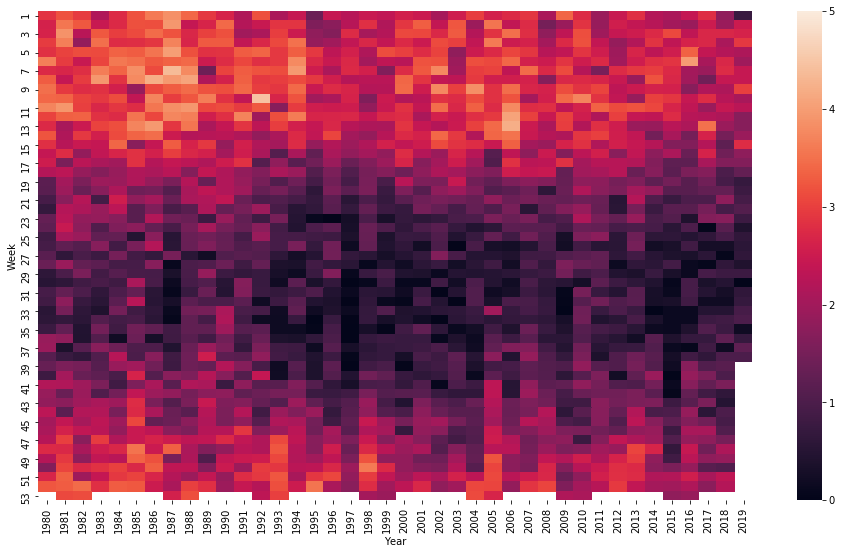

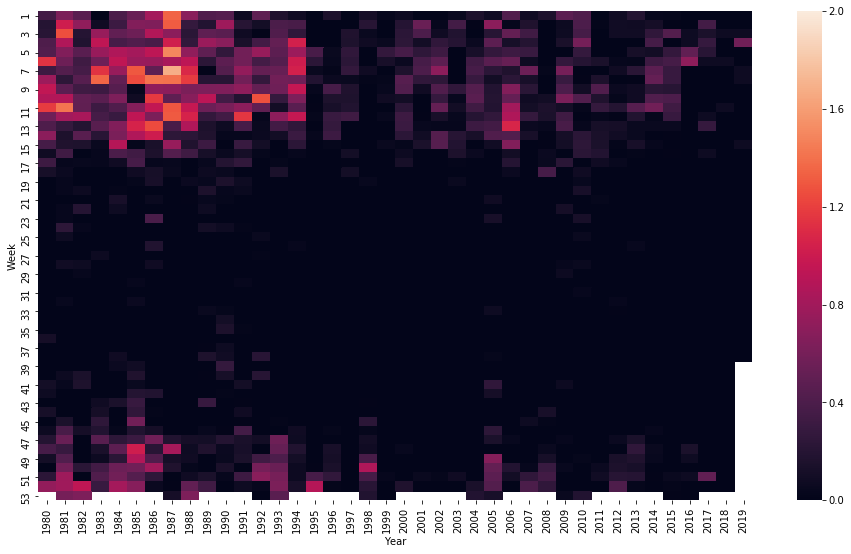

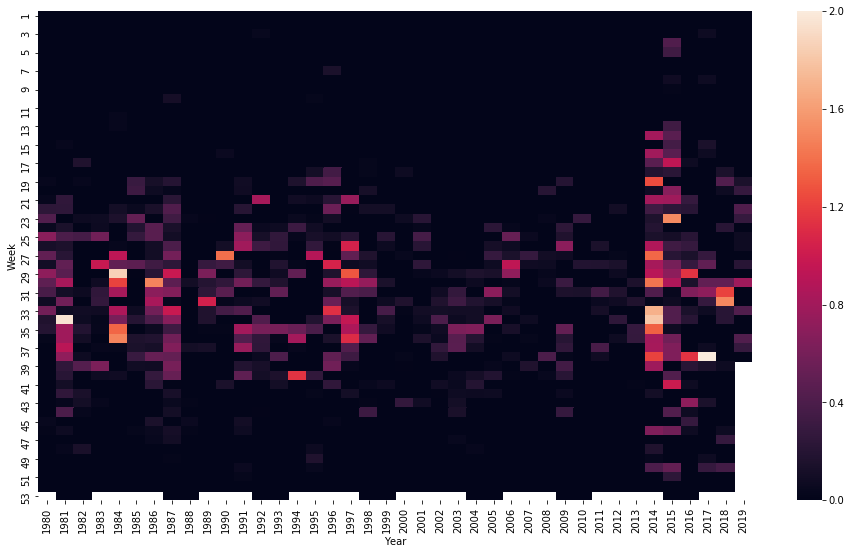

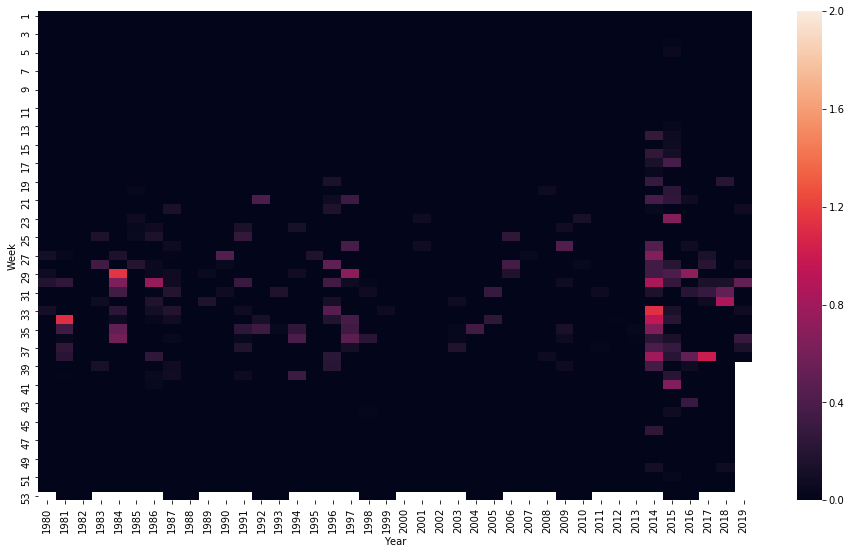

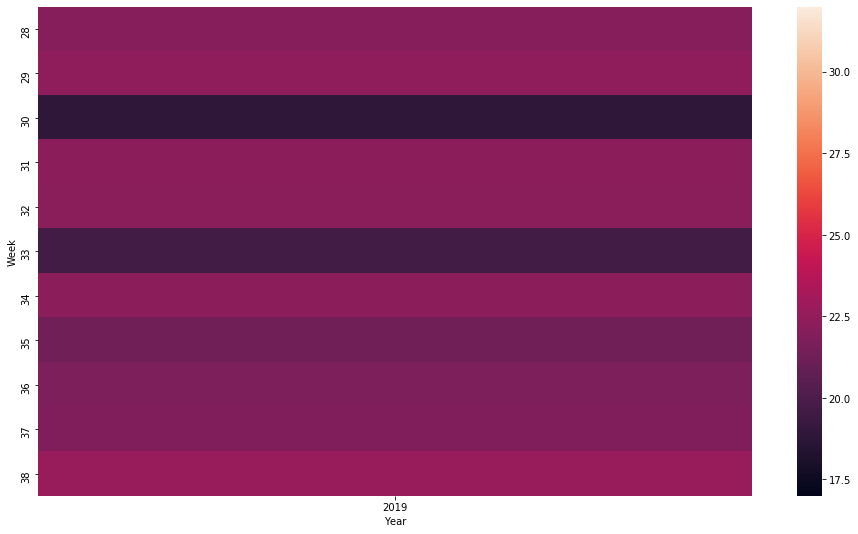

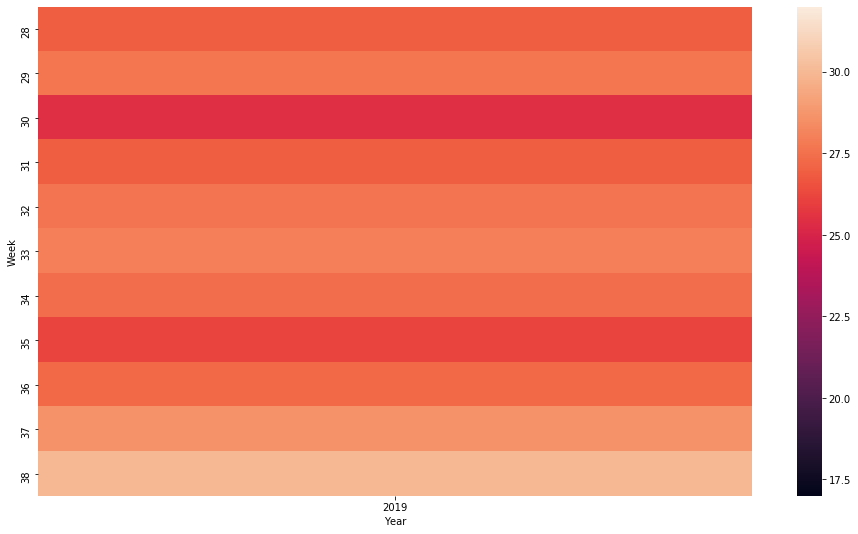

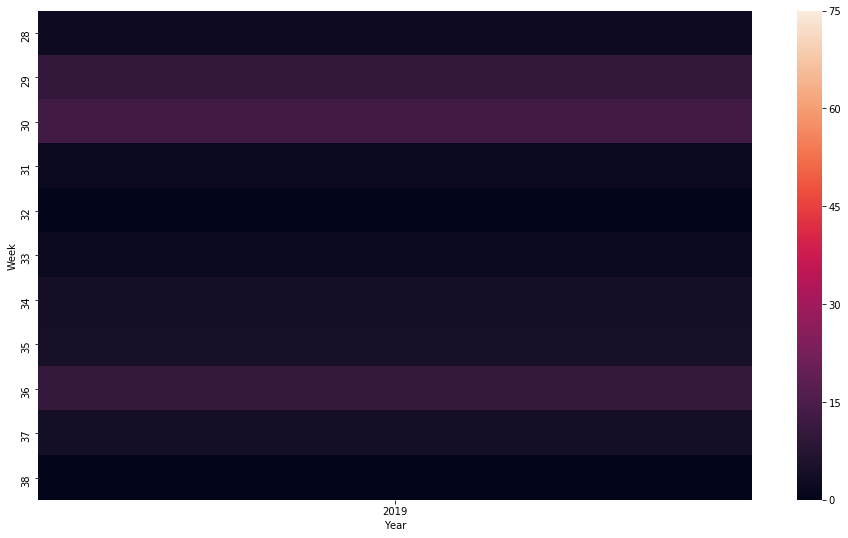

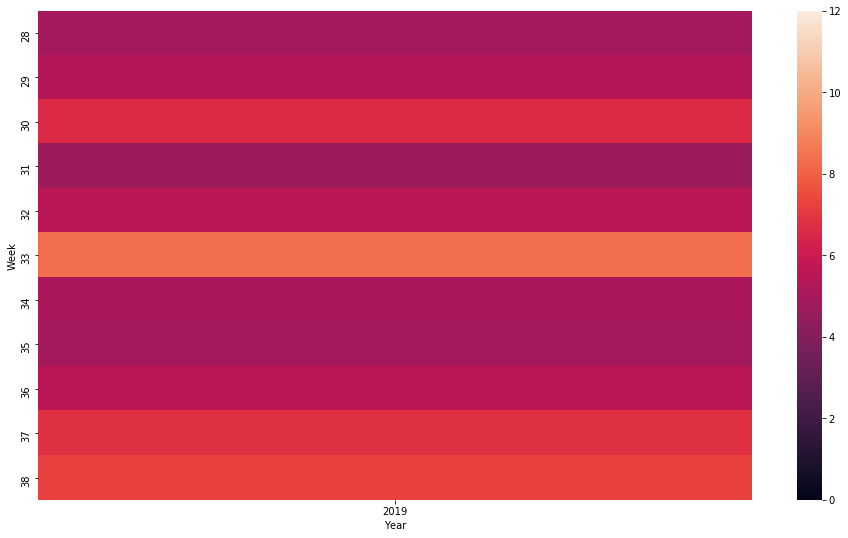

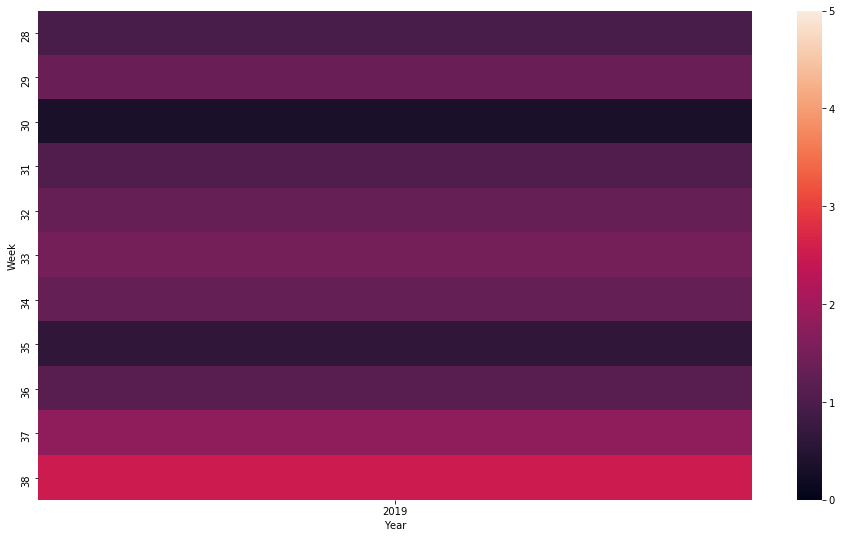

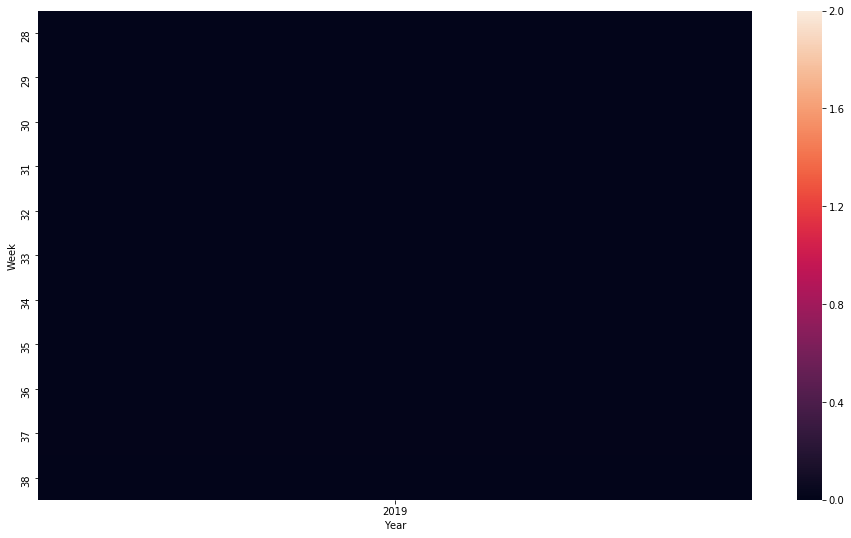

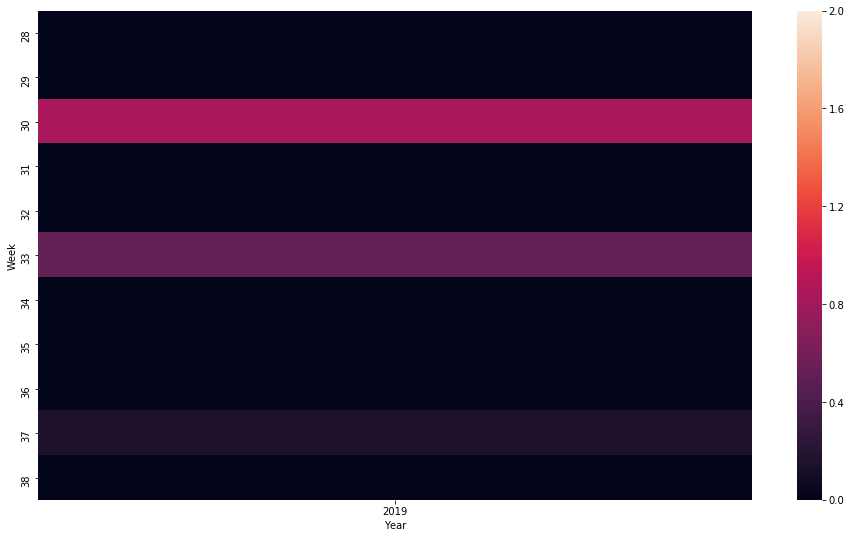

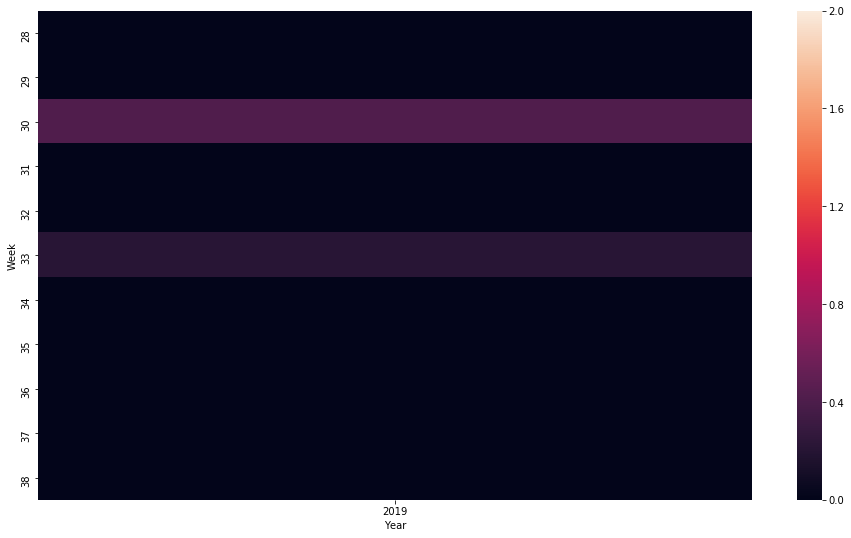

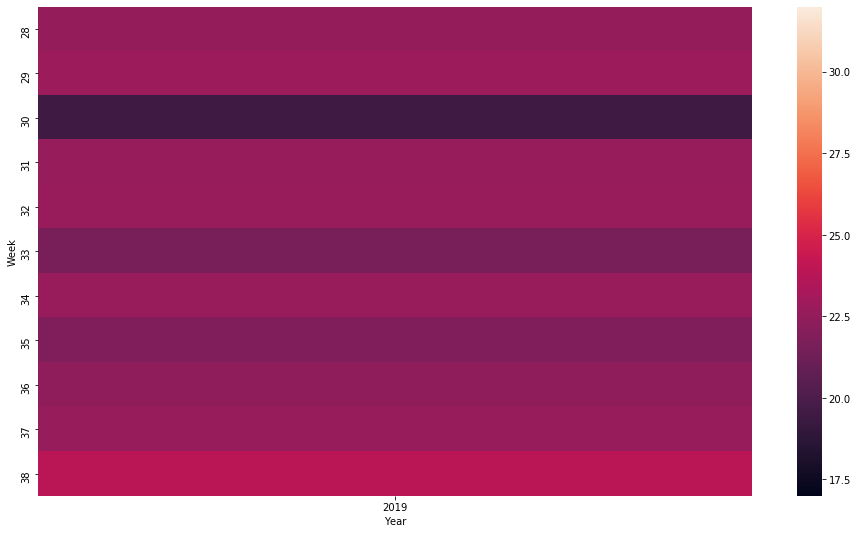

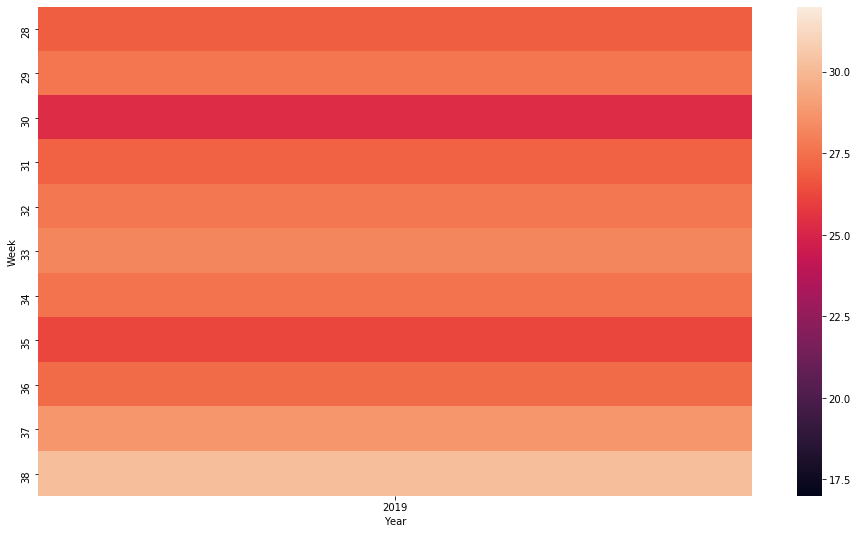

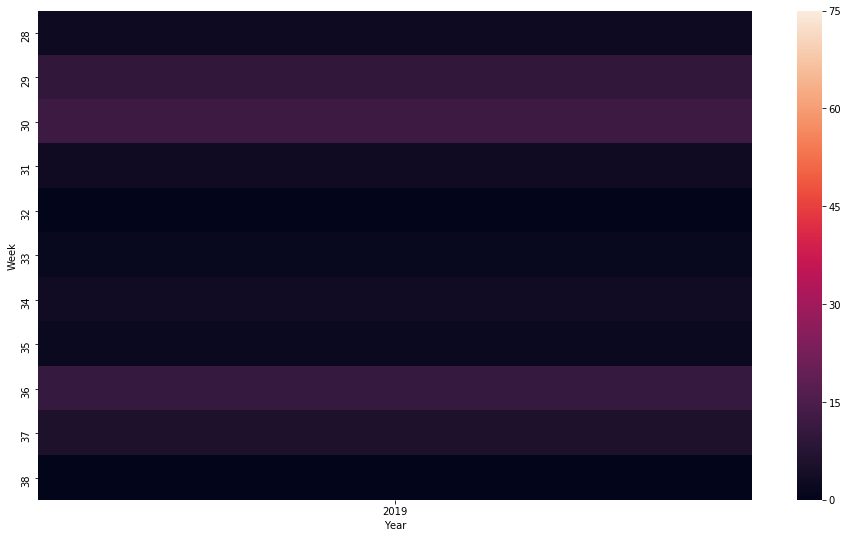

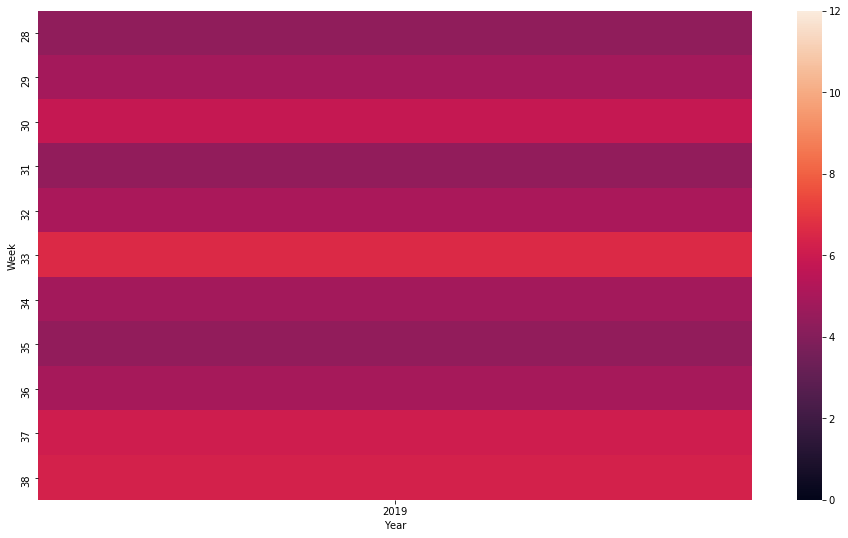

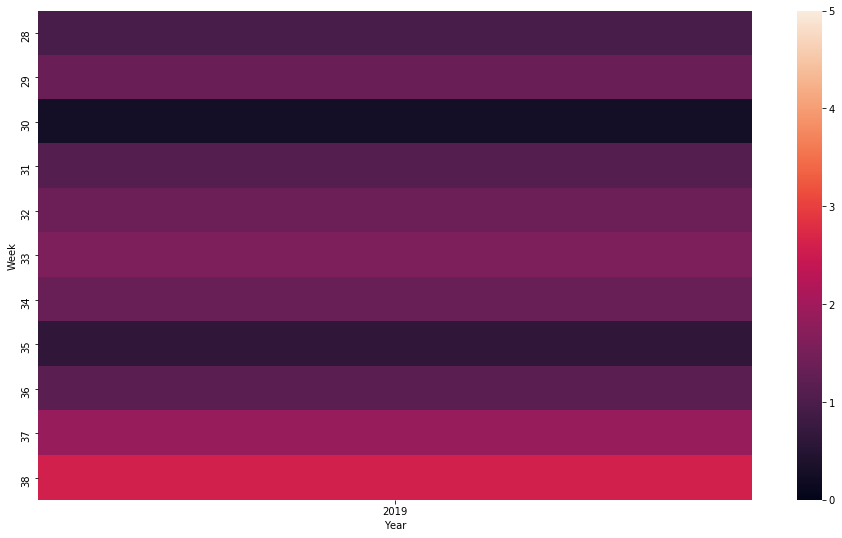

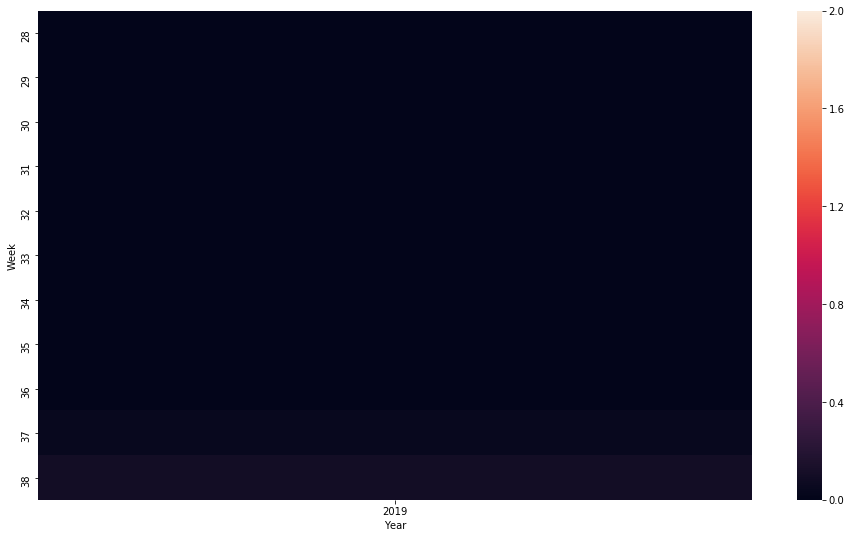

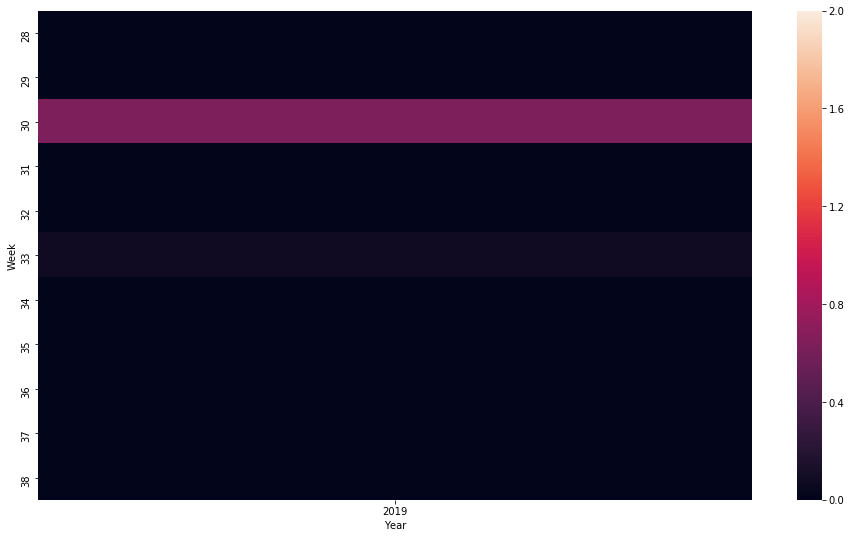

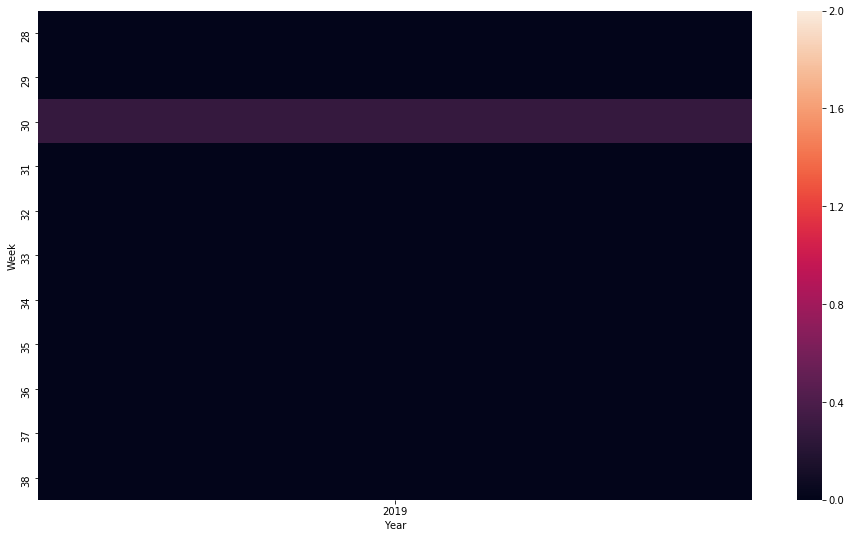

C:\Users\HRADXY\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\matrix.py:287: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
C:\Users\HRADXY\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\matrix.py:287: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


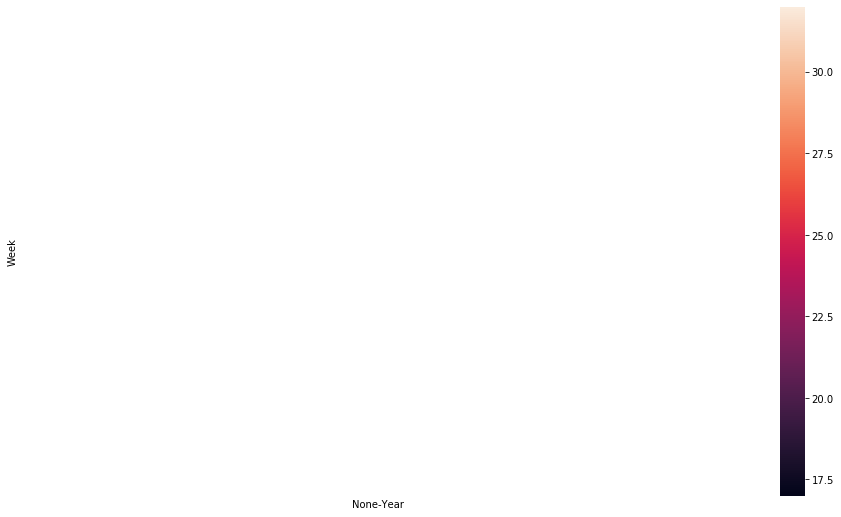

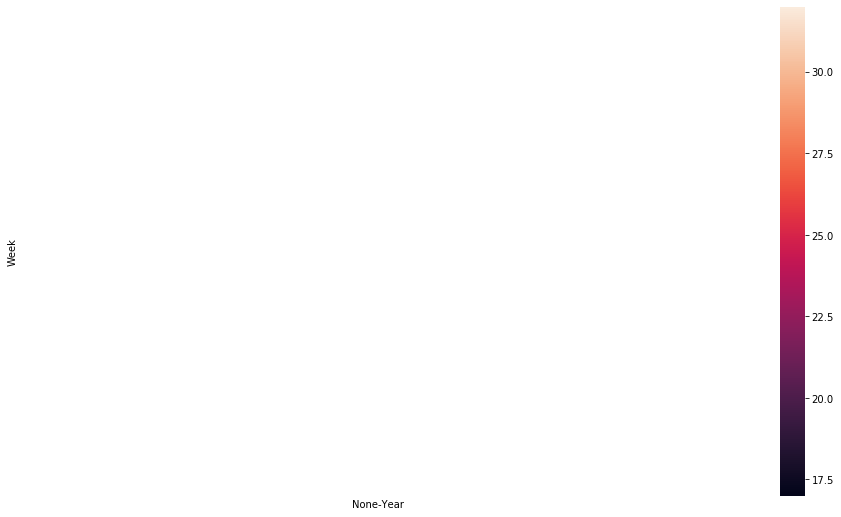

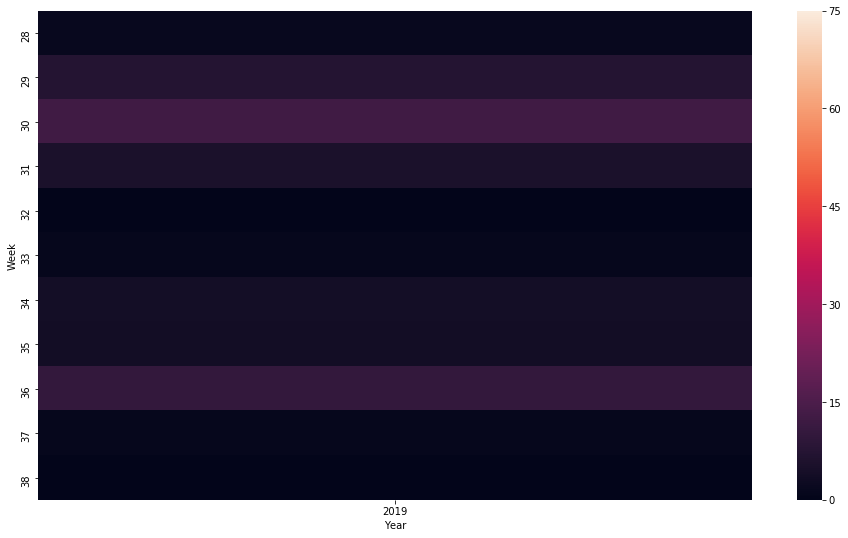

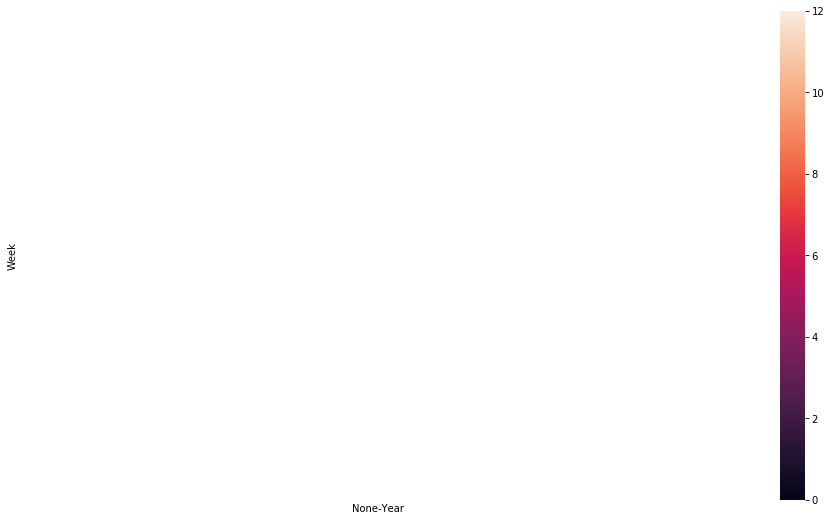

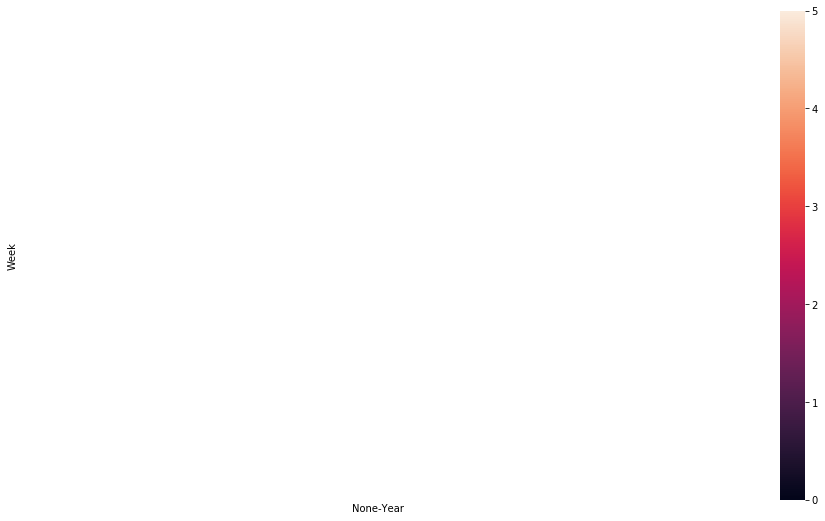

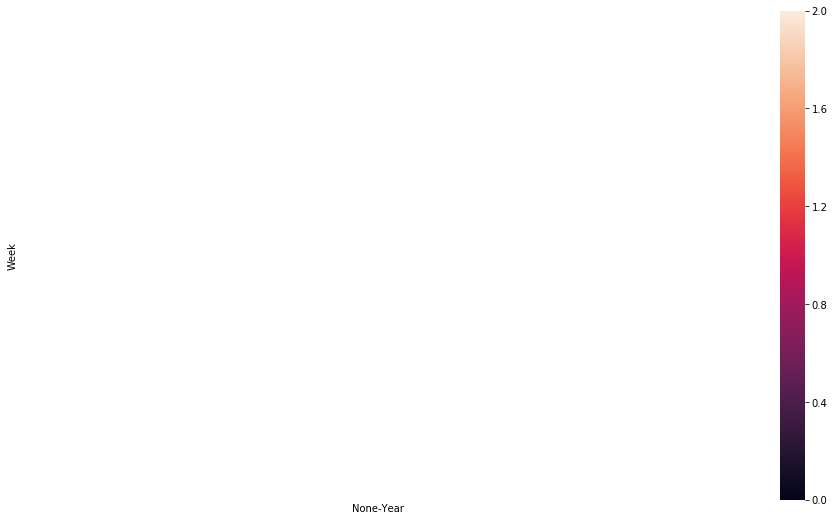

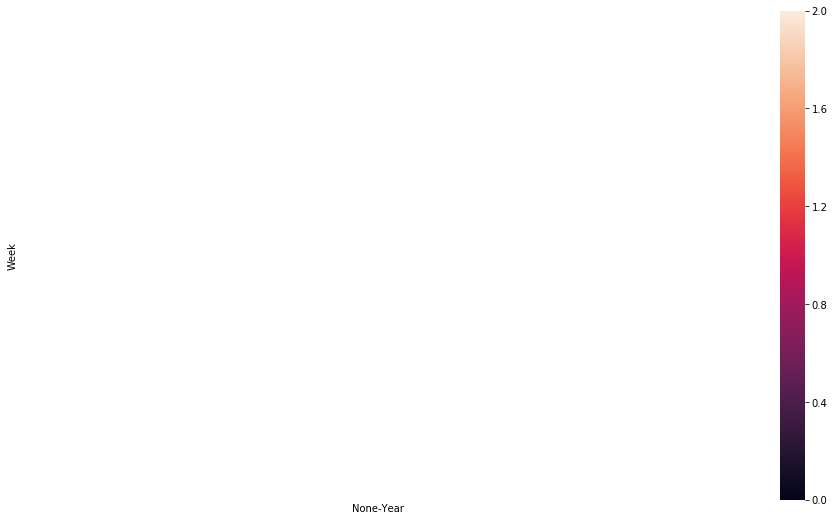

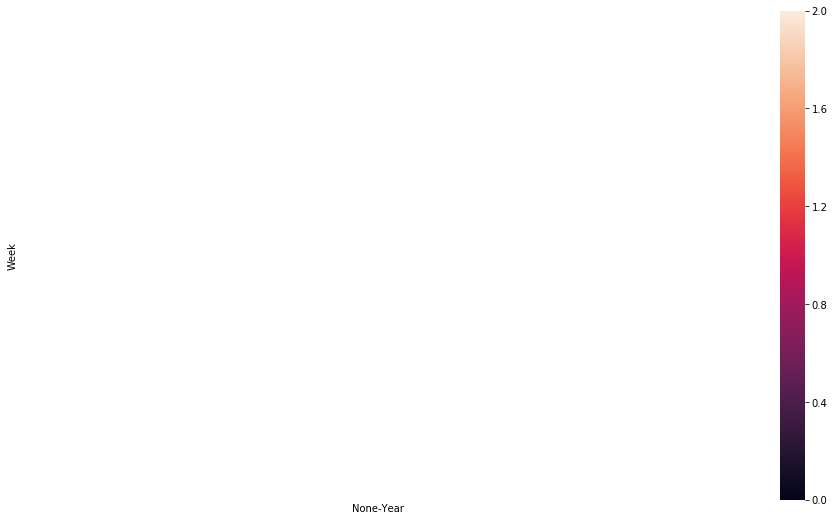

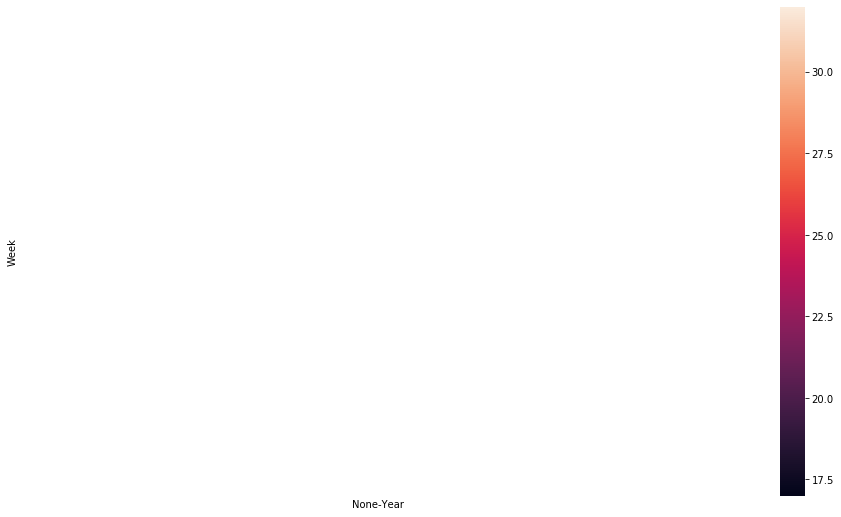

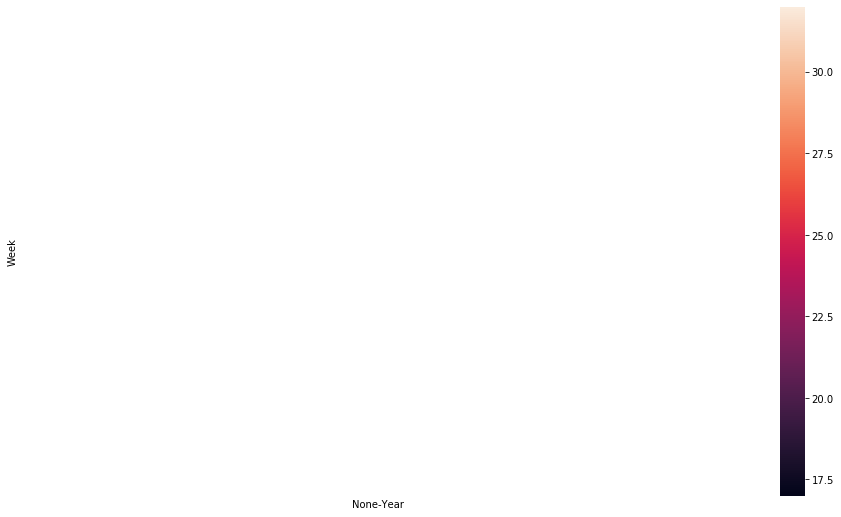

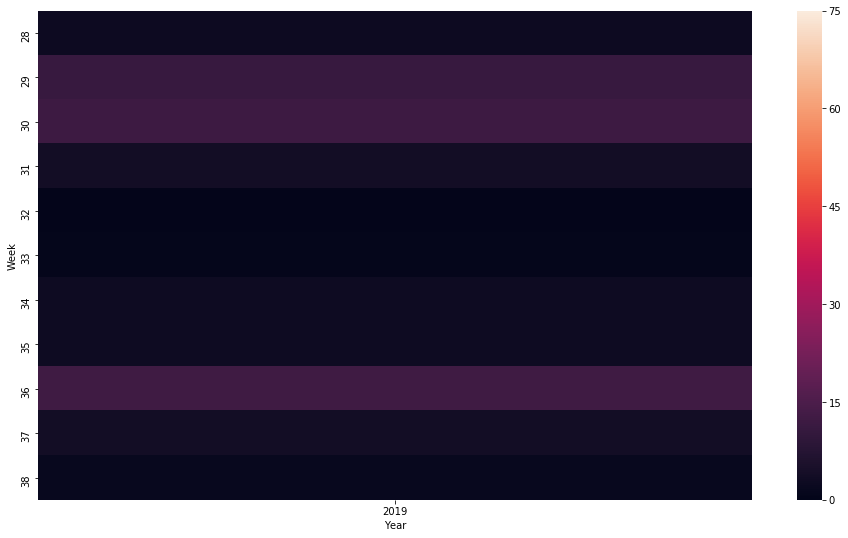

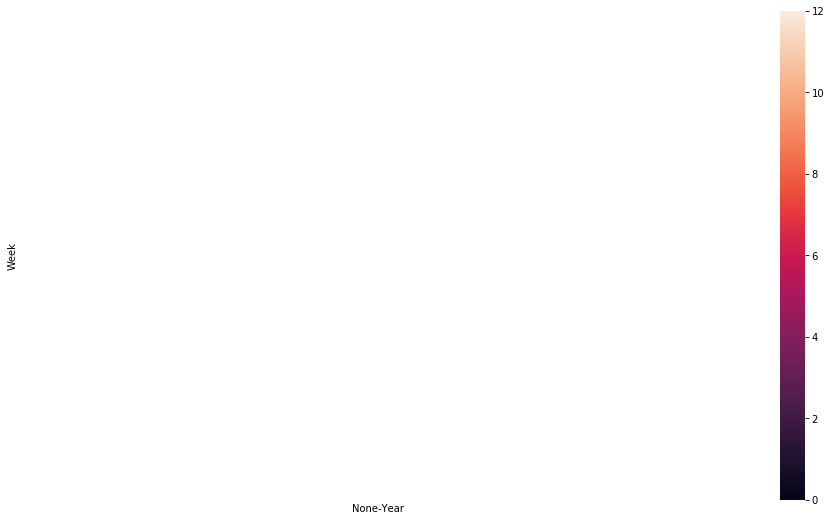

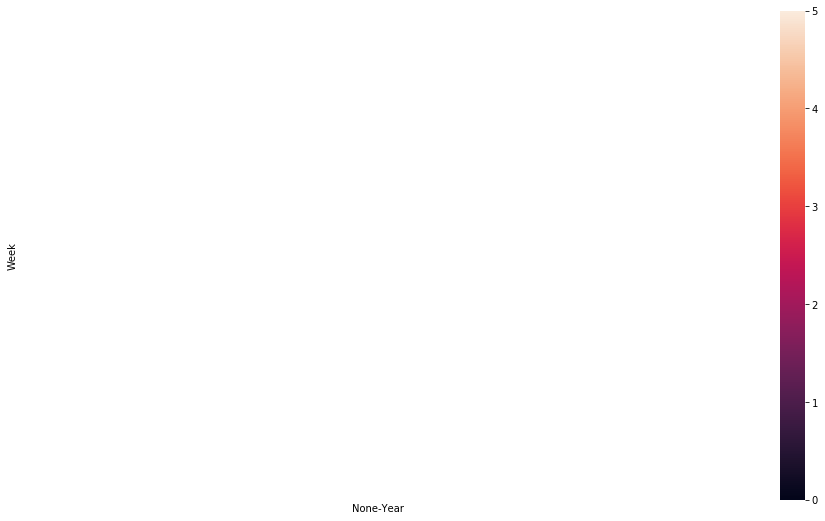

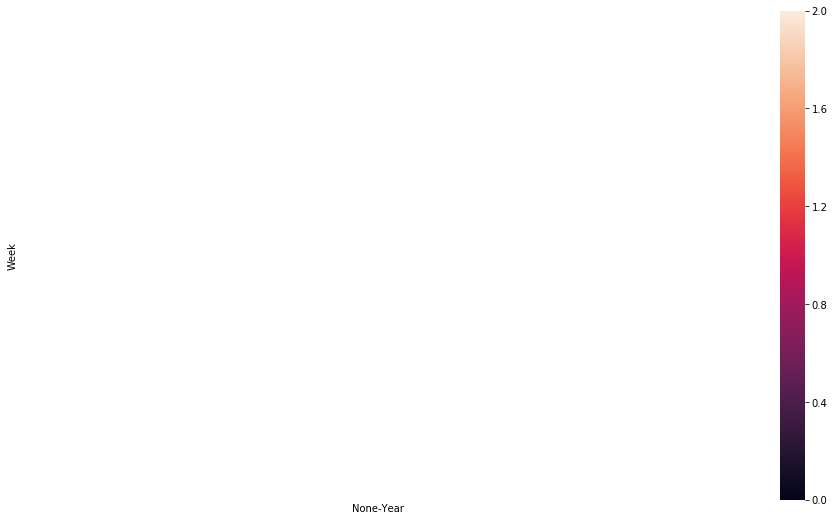

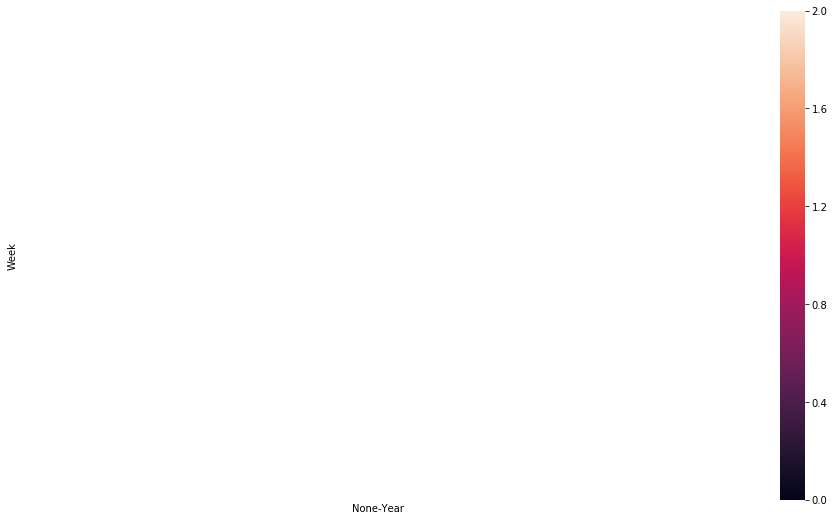

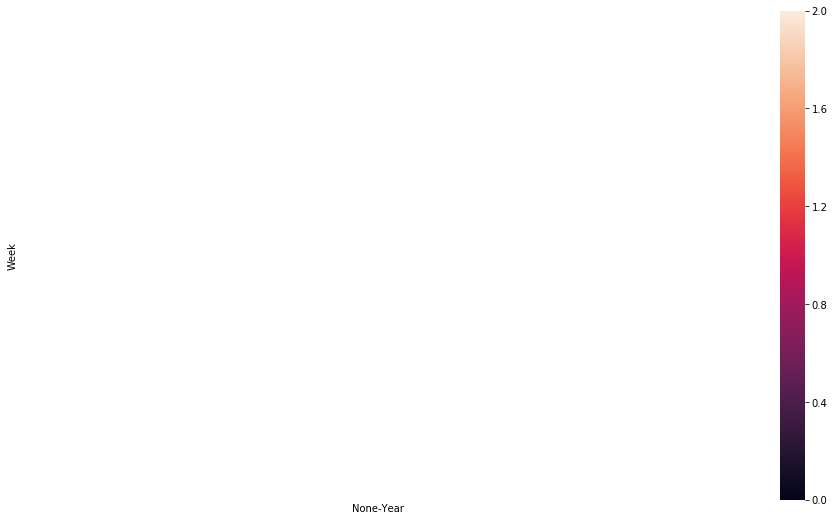

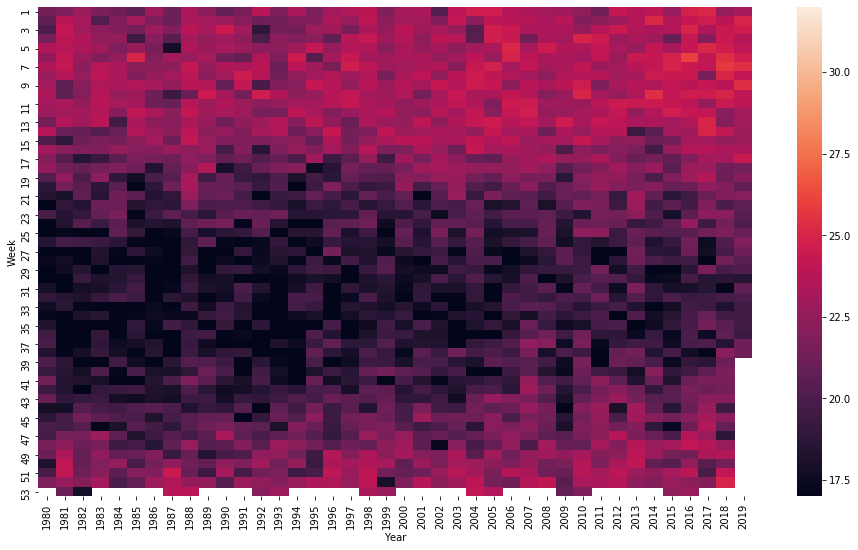

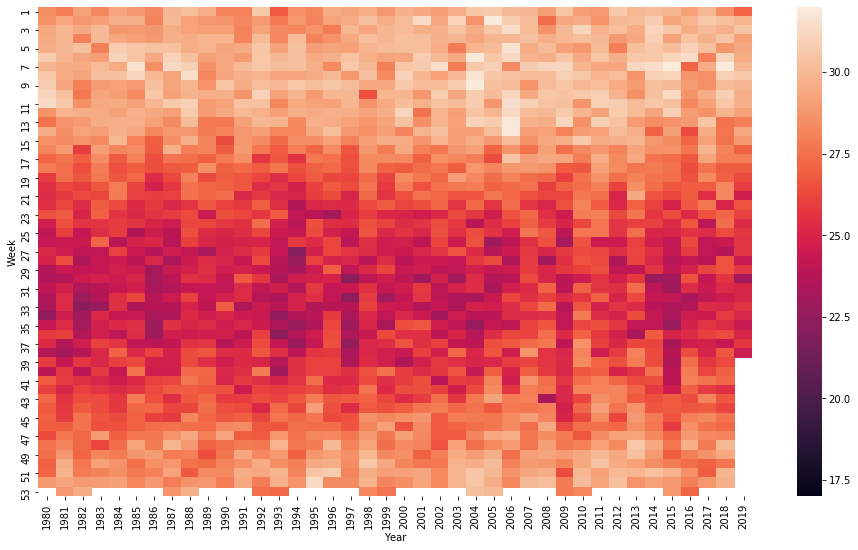

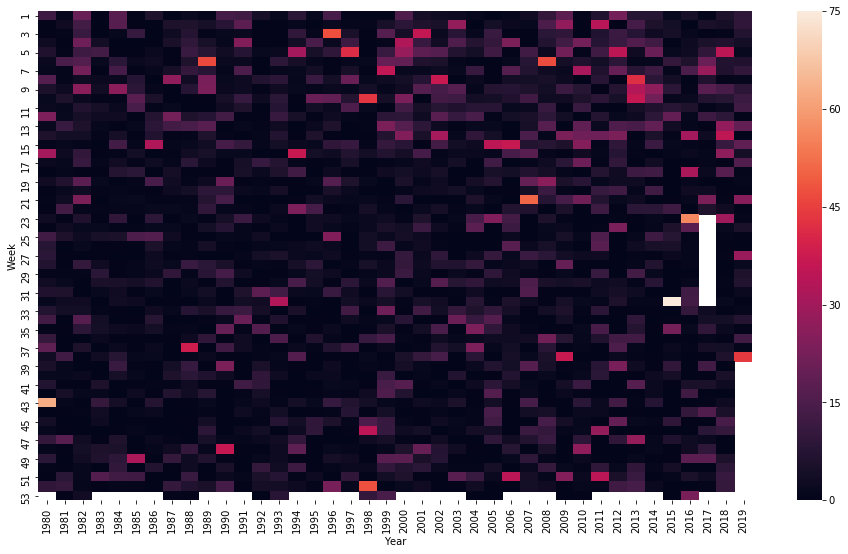

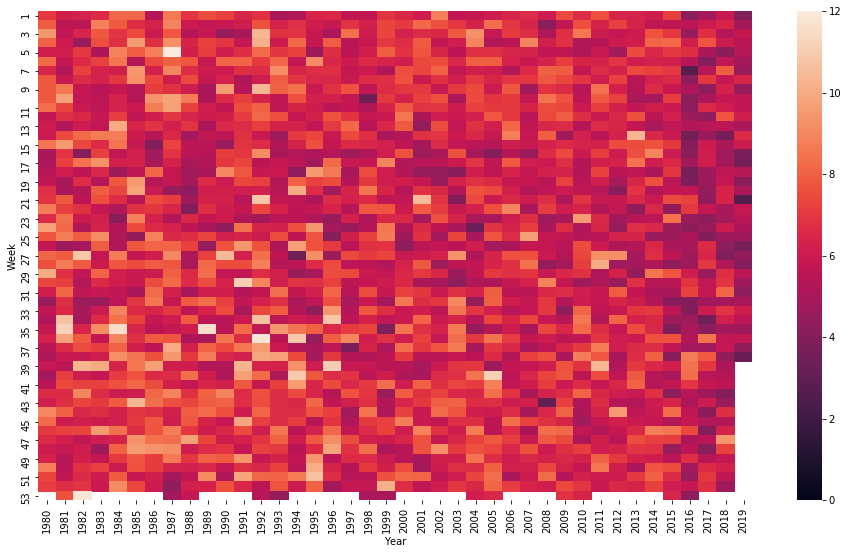

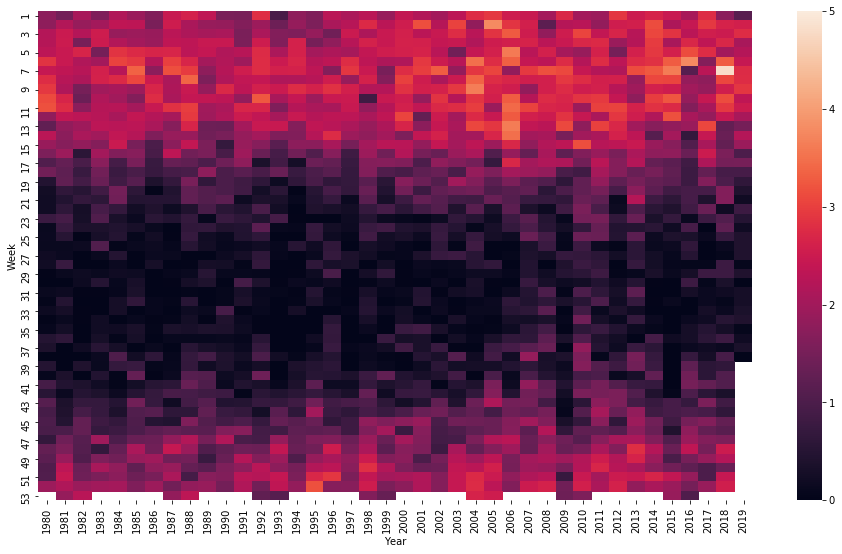

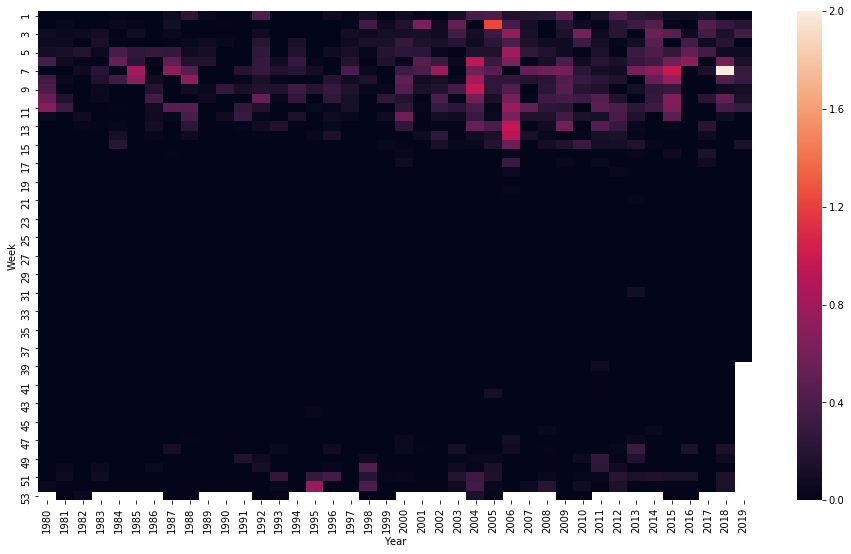

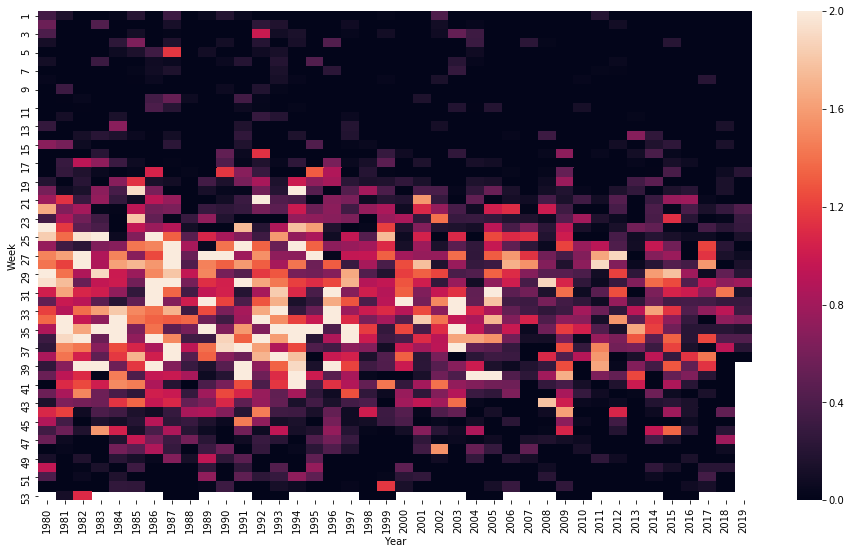

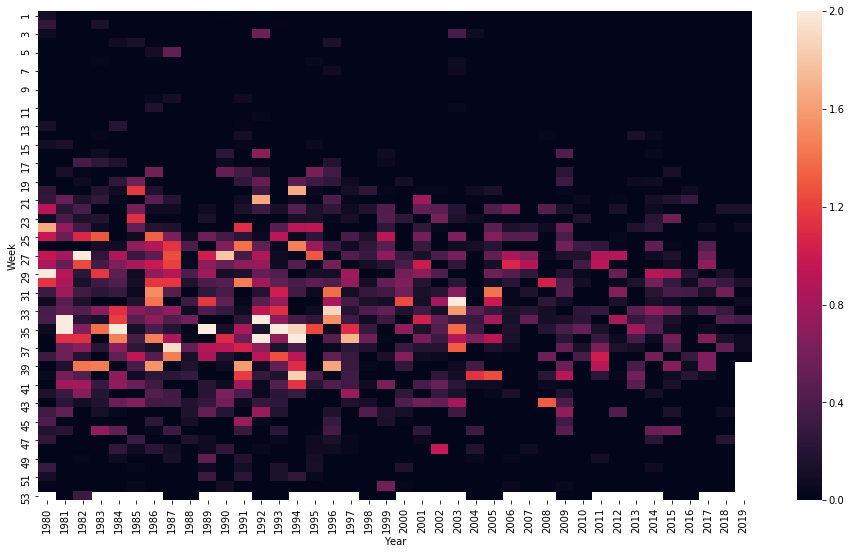

In [6]:
#Generating figures and writing to disk as PNG files
for station in station_ids.keys():
    #Read excel file into memory
    frame = pd.read_excel(station+'-01011980 to '+end_date_filename+'.xls', header=0).fillna(np.nan)
    #Generating heatmaps
    for figure in figure_dict.keys():
        htmp = pd.pivot_table(frame,index='Week',columns='Year',values = figure_dict[figure]['df_column'],aggfunc=np.mean)
        fig, ax = plt.subplots(figsize=(16,9))
        sns.heatmap(htmp,vmin = figure_dict[figure]['min_val'], vmax = figure_dict[figure]['max_val'])
        plt.show()
        fig.savefig(station+' - '+figure_dict[figure]['name']+'.png')

Vavau - Growing Degree Days over 25C.png


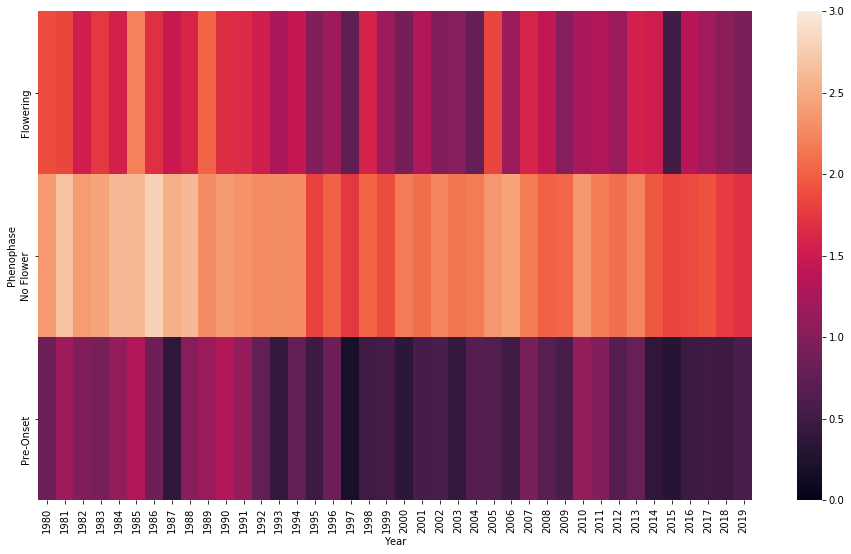

Vavau - Heat Days over 30C.png


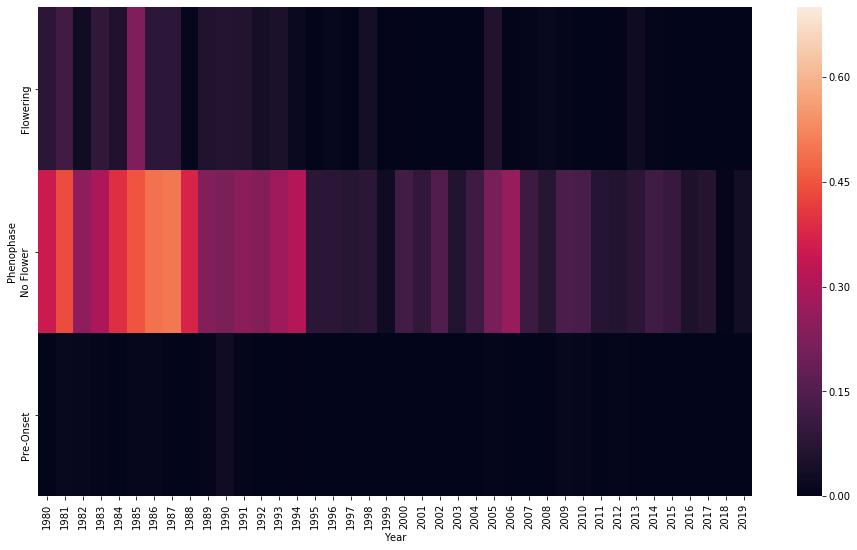

Vavau - Chill Days under 20C.png


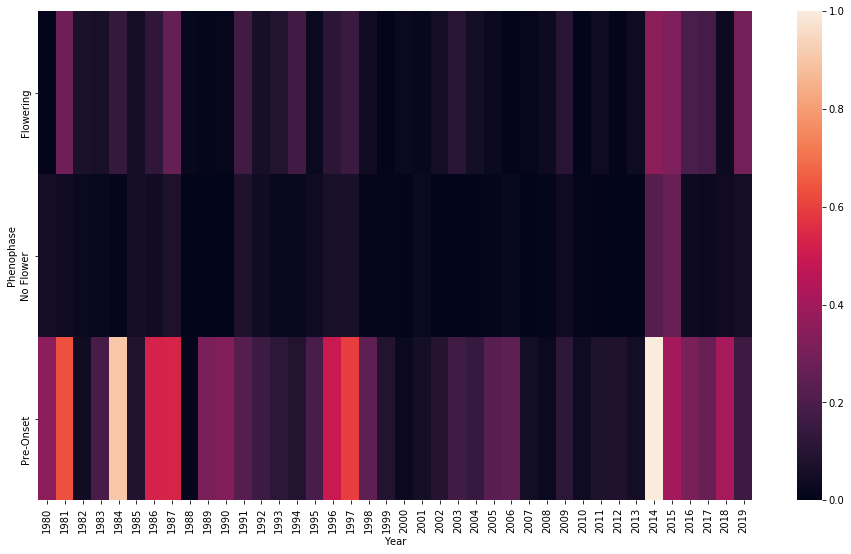

Vavau - Chill Days under 18C.png


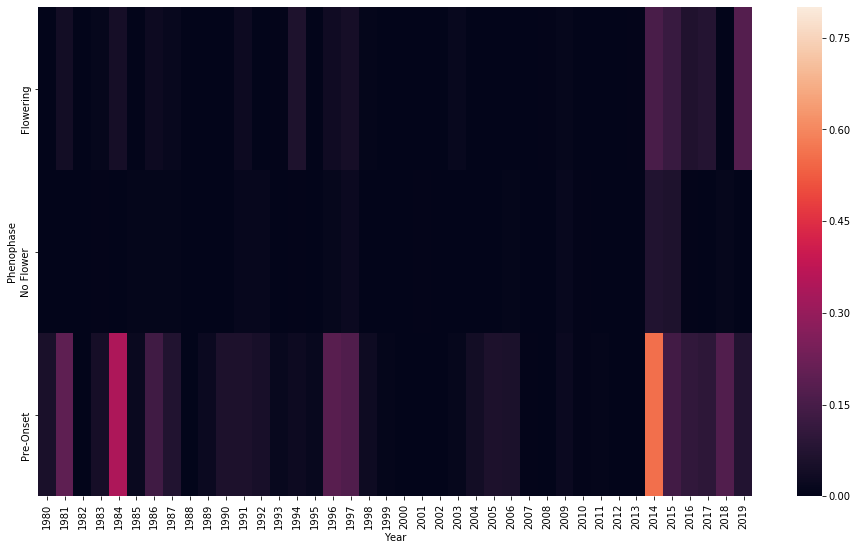

Tongatapu - Growing Degree Days over 25C.png


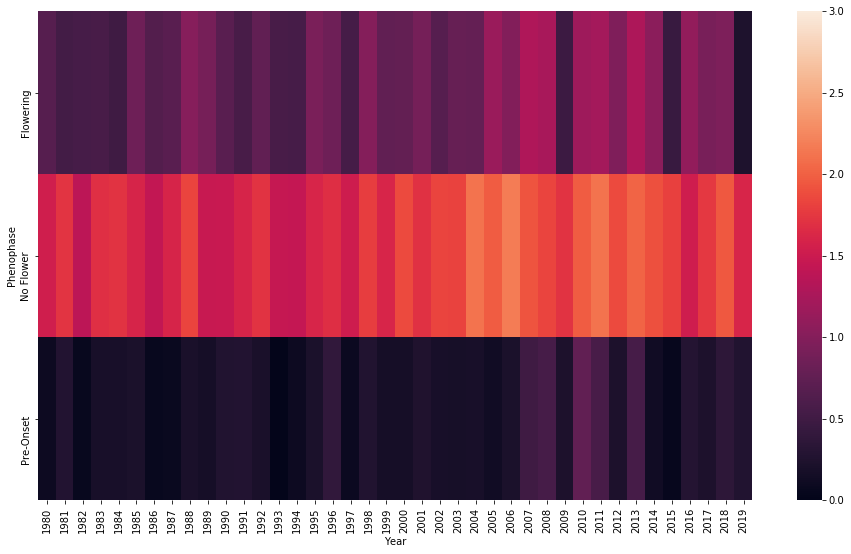

Tongatapu - Heat Days over 30C.png


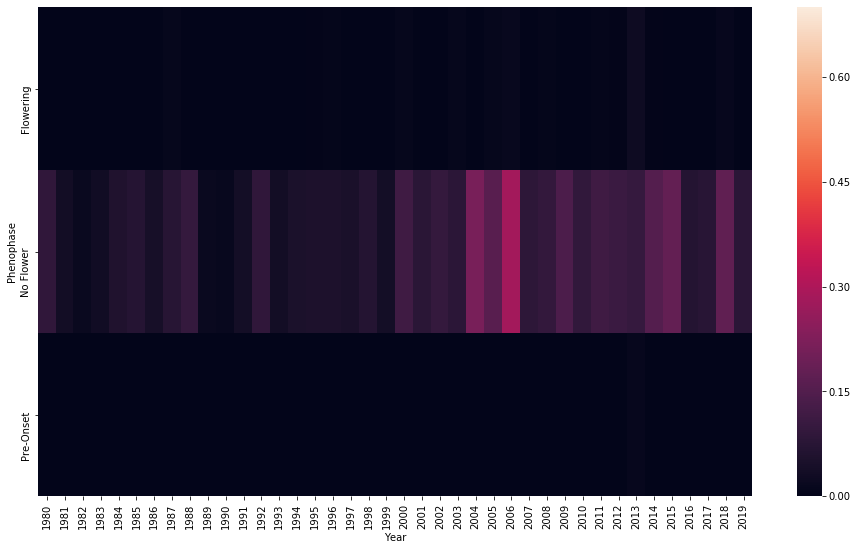

Tongatapu - Chill Days under 20C.png


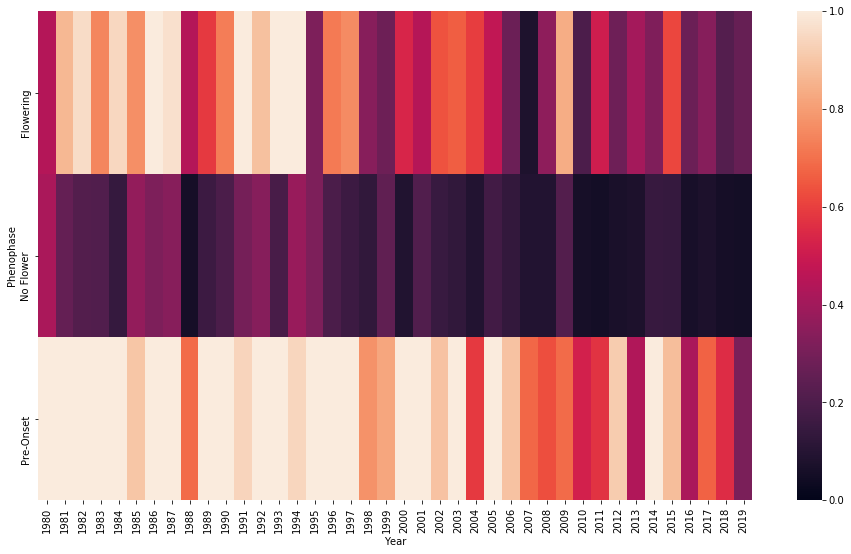

Tongatapu - Chill Days under 18C.png


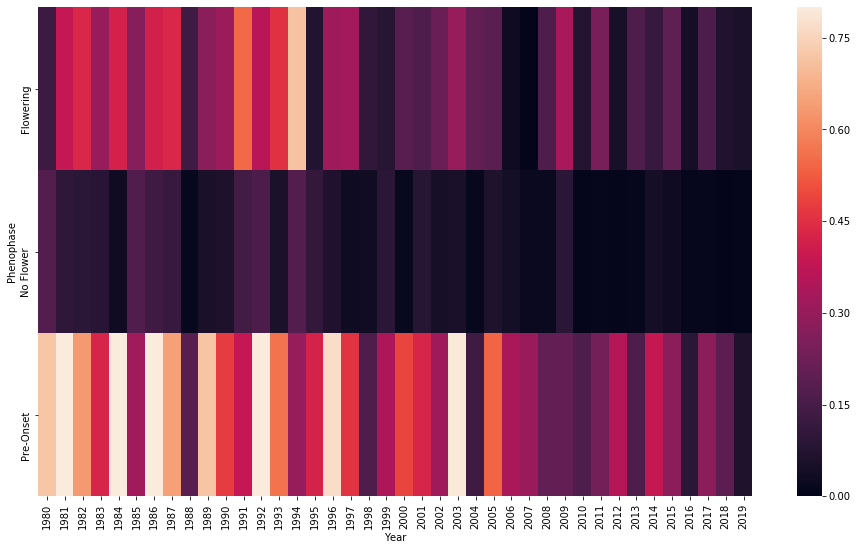

In [8]:
figure_dict = {
    'GDD_25':{'min_val':0, 'max_val':3, 'name':'Growing Degree Days over 25C', 'df_column':'GDD_25'},
    'Heat_30':{'min_val':0, 'max_val':0.7, 'name':'Heat Days over 30C', 'df_column':'Heat_30'},
    'Chill_20':{'min_val':0, 'max_val':1, 'name':'Chill Days under 20C', 'df_column':'Chill_20'},
    'Chill_18':{'min_val':0, 'max_val':0.8, 'name':'Chill Days under 18C', 'df_column':'Chill_18'}
}

station_ids = {
        'Vavau':3,
        'Tongatapu':1
}

#Generating figures and writing to disk as PNG files
for station in station_ids.keys():
    #Read excel file into memory
    frame = pd.read_excel(station+'-01011980 to '+end_date_filename+'.xls', header=0).fillna(np.nan)
    frame['Phenophase'] = frame['Phenophase'].replace({'NF':'No Flower'})
    #Generating heatmaps
    for figure in figure_dict.keys():
        table_sum = pd.pivot_table(frame,index='Phenophase',columns='Year',values = figure_dict[figure]['df_column'],aggfunc=np.sum)
        table_sum.to_excel(station+' - '+figure_dict[figure]['name']+' by phenophase.xls')
        htmp = pd.pivot_table(frame,index='Phenophase',columns='Year',values = figure_dict[figure]['df_column'],aggfunc=np.mean)
        fig, ax = plt.subplots(figsize=(16,9))
        sns.heatmap(htmp,vmin = figure_dict[figure]['min_val'], vmax = figure_dict[figure]['max_val'])
        print(station+' - '+figure_dict[figure]['name']+'.png')
        plt.show()
        fig.savefig(station+' - '+figure_dict[figure]['name']+' - phase mean.png')